TODO: INCREASE LIMIT IN OVERALL RESULTS (50) BUT ADD LIMITS TO RERANK CHAIN SO THAT MORE RESULTS ARE AVAILABLE TO RERANK BUT THE FINAL OUTPUT ONLY HAS A FEW RESULTS (5-10)

# Introducing User Defined Function Reranking

Vectara has several out of the box rerankers, including [Maximal Marginal Revelance (MMR)](https://docs.vectara.com/docs/learn/vectara-multi-lingual-reranker) and a [Multilingual Reranker](https://docs.vectara.com/docs/learn/mmr-reranker).

If you would like more control over how the search results are reranked, the [User Defined Function (UDF)](https://docs.vectara.com/docs/learn/user-defined-function-reranker) reranker is just for you! This reranker gives you the ability to use different operators and expressions to define how your retrieved search results are reranked based on document or part metadata.

The best way to use the UDF reranker is with our [chain reranker](https://docs.vectara.com/docs/learn/chain-reranker), allowing you to use multiple rerankers in a sequence to re-order the retrieved search results. Our recommended reranking strategy is to use the sequence:

1. Multilingual
2. MMR
3. UDF

**Important Note:** When using the multilingual reranker in chain reranking, it must be used first. If you use it later on in the chain, all previous reranking steps will be ignored.

In this notebook, we will demonstrate many of the capabilities of the UDF reranker using a corpus that contains reviews for Airbnb listings in Barcelona. We will compare the results of using the UDF reranker in the above reranking chain against the same query that uses the multilingual and MMR rerankers.

In [1]:
import os

corpus_key = os.getenv("VECTARA_CORPUS_KEY")
api_key = os.getenv("VECTARA_API_KEY")

### BRAINSTORMING

Baseline comparison should be against Multilingual + MMR.

Do a metadata filter on room type. Explain that this is something to filter by and not to rerank with.

Use plotly to plot the top search results on a map (as a fun thing at the end) (can show comparison between results with and without UDF when using location/distance function).

Put this in some example:

One important distinction to make is the difference between UDF reranking and metadata filtering. If the operations subsets search results to only contain a certain metadata attribute, you should use the `metadata_filter` argument in your query body (e.g. if you only want to see listings that are less than $400). However, if the operation **sorts** the search results based on some metadata attribute, then you should use the UDF reranker (e.g if you want to sort the listings by price from least expensive to most expensive).

## Basic Sorting

Let's start off with a simple use case with udf reranking. When looking for an Airbnb, you will probably be most interested in the highest rated Airbnb listings. To do this, we will add a function to our rerank chain that favors reviews on listings with higher ratings. This function will be:

`5 * get('$.score') + get($.part_metadata.overall_rating)` PLAY WITH COEFFICIENT

In almost every UDF function, you will see `get('$.score')`. This function retrieves the current reranking score for each of the documents based on the previous retrieval and reranking strategies. After the first set of documents are retrieved, this value will range from 0 to 1. After this, the range of the score will depend on your other rerankers. One important thing to keep in mind when defining your user defined functions is that this score should always be non-negative, so make sure that any function you define always outputs non-negative values.

The number 5 in the above expression is somewhat arbitrary. This coefficient is simply scaling the weight between the importance of the previous reranking score and the overall rating of the Airbnb listing. You may have to play with these sorts of coefficients until you get the desired scaling for your application. When testing with different values, consider the possible range of values for each of the variables in your expression. In our expression, the `score` will range from 0 to 1 and the `document_metadata.overall_rating` will range from 1 to 5 (because the star rating system on Airbnb ranges from 1 to 5).

Let's now see how to include this function in an API request and compare the results against an example that does not use this expression.

In [7]:
# Without UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that is very clean and well maintained.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 10,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [21]:
for result in res['search_results']:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\n")

Review: Host was amazing, very responsive and helpful. Clear and concise instructions given. The airbnb was very clean and well maintained. The location was perfect, everything was in walking distance
Score: 0.9923638105392456
Overall Rating: 4.74

Review: Great Airbnb in a great location. Very walkable area. Clean and well maintained AirBnB
Score: 0.5877608060836792
Overall Rating: 4.91

Review: Jessy is a very hospitable and friendly host, and her dogs are absolutely adorable! She gave us great travel tips and made us feel very welcome. The Airbnb is small but well-maintained and kept very clean. Convenient access to public transportation. The room was fine for two small people, but could be challenging for larger people or those with mobility issues, especially the bathroom. Also there was some noise issues due to the washing machine and neighbors. Overall, still a solid place in a quieter and quaint part of Barcelona for those looking to escape touristy areas and experience local l

In [22]:
# With UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that is very clean and well maintained.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 10,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "5 * get('$.score') + get($.document_metadata.overall_rating)"
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [23]:
for result in res['search_results']:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\n")

Review: Host was amazing, very responsive and helpful. Clear and concise instructions given. The airbnb was very clean and well maintained. The location was perfect, everything was in walking distance
Score: 0.9923638105392456
Overall Rating: 4.74

Review: Great Airbnb in a great location. Very walkable area. Clean and well maintained AirBnB
Score: 0.5877608060836792
Overall Rating: 4.91

Review: Jessy is a very hospitable and friendly host, and her dogs are absolutely adorable! She gave us great travel tips and made us feel very welcome. The Airbnb is small but well-maintained and kept very clean. Convenient access to public transportation. The room was fine for two small people, but could be challenging for larger people or those with mobility issues, especially the bathroom. Also there was some noise issues due to the washing machine and neighbors. Overall, still a solid place in a quieter and quaint part of Barcelona for those looking to escape touristy areas and experience local l

## Math Operations

Another important consideration when choosing the right Airbnb is the location. Suppose that you want to find an Airbnb that is close to many of the top attractions in Barcelona so that your travel time is minimized on your trip. We can add a user defined function that calculates the distance between the Airbnb and another location, such as Casa Batlló, a historic landmark in Barcelona that is close to other popular attractions like Basílica de la Sagrada Família and Plaça de Catalunya. To calculate the distance between each Airbnb and this attraction, we will use the latitude and longitude coordinates of the Airbnb and calculate the distance to Casa Batlló (latitude: 41.39283635783124, longitude: 2.164614185406772) using the equirectangular approximation, defined as $$R* \sqrt{\Delta\phi^2 + (cos(\frac{\phi_1 + \phi_2}{2}) * \Delta\lambda)^2},$$

where $R$ is the radius of Earth (about 6371 km) $\phi_1$ and $\phi_2$ are the latitudes of the two points in radians and $\lambda_1$ and $\lambda_2$ are the longitudes of the two points in radians.

For example, if we want to calculate the distance between Basílica de la Sagrada Família (latitude: 41.4037272046833, longitude: 2.174643481526023) and Spotify Camp Nou (latitude: 41.380900633873445, longitude: 2.123142814772147), the stadium where Barcelona plays, we will use the latitude and longitude of these locations and plug them into the above equation (Remember that these coordinate values are in degrees, so we must convert them to radians first):

$$\phi_1 = 41.4037272046833 (\frac{\pi}{180}) = 0.722711$$
$$\phi_2 = 41.380900633873445 (\frac{\pi}{180}) = 0.722312$$
$$\lambda_1 = 2.174643481526023 (\frac{\pi}{180}) = 0.037954$$
$$\lambda_2 = 2.123142814772147 (\frac{\pi}{180}) = 0.037055$$

$$Distance \approx 6371 * \sqrt{(0.722312 - 0.722711)^2 + (cos(\frac{0.722711 + 0.7223125}{2}) * (0.037055 - 0.037954))^2} = 4.99 km$$

Since the radius of Earth is just a constant and we don't care about the actual value outputted by this function, we will remove this constant from our distance calculation in the `user_function`. Using the available functions in the udf reranker, this looks like

`get('$.score') -  200 * sqrt(power(radians(get('$.document_metadata.latitude')) - radians(41.39283635783124)), 2) + power(cos((radians(get('$.document_metadata.latitude')) + radians(41.39283635783124)) / 2) * (radians(get('$.document_metadata.longitude')) - radians(2.164614185406772)), 2))`

Once again, the coefficient of 200 is sort of arbitrary, but we select this value based on how much we want to weigh the importance of the previous reranking score with the distance from the Airbnb to Casa Batlló.

Let's see how the results differ when we add in this UDF reranker.

In [30]:
# Without UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 10,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [31]:
for result in res['search_results']:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nLatitude: {result['document_metadata']['latitude']}\nLongitude: {result['document_metadata']['longitude']}\n")

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing everything, if it's not a short walk its a short cab ride. The apartment is large with plenty of space, three bedrooms, one double, one larger single and bunk beds. Two bathrooms, one full shower and one half. Full kitchen and large living/dining room.  Its a walk up, maybe 5 short flights of stairs. Next time I'm in Barcelona I'll definitely try and stay here.
Score: 0.9472835659980774
Latitude: 41.40735
Longitude: 2.15885

Review: If youre looking for an airbnb in Barcelona look no further! The place looks great, is very clean and the staff is great. You get hotel quality with the advantages that an airbnb has to offer like a nice full kitchen. The location is also very central to everything in the city. You can easily take the metro anywhere. The ba

In [32]:
# With UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 10,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": """
                            get('$.score') -  200 * sqrt(power(radians(get('$.document_metadata.latitude')) - radians(41.39283635783124)), 2) +
                            power(cos((radians(get('$.document_metadata.latitude')) + radians(41.39283635783124)) / 2) *
                                    (radians(get('$.document_metadata.longitude')) - radians(2.164614185406772)), 2))
                            """
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

udf_response = requests.request("POST", url, headers=headers, data=payload)
udf_res = udf_response.json()

In [33]:
for result in udf_res['search_results']:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nLatitude: {result['document_metadata']['latitude']}\nLongitude: {result['document_metadata']['longitude']}\n")

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing everything, if it's not a short walk its a short cab ride. The apartment is large with plenty of space, three bedrooms, one double, one larger single and bunk beds. Two bathrooms, one full shower and one half. Full kitchen and large living/dining room.  Its a walk up, maybe 5 short flights of stairs. Next time I'm in Barcelona I'll definitely try and stay here.
Score: 0.9472835659980774
Latitude: 41.40735
Longitude: 2.15885

Review: If youre looking for an airbnb in Barcelona look no further! The place looks great, is very clean and the staff is great. You get hotel quality with the advantages that an airbnb has to offer like a nice full kitchen. The location is also very central to everything in the city. You can easily take the metro anywhere. The ba

### Visual Comparison

In the maps below, we can see that the results returned by the query with the udf function are closer to the main attractions in Barcelona compared to the query that does not use the udf function.

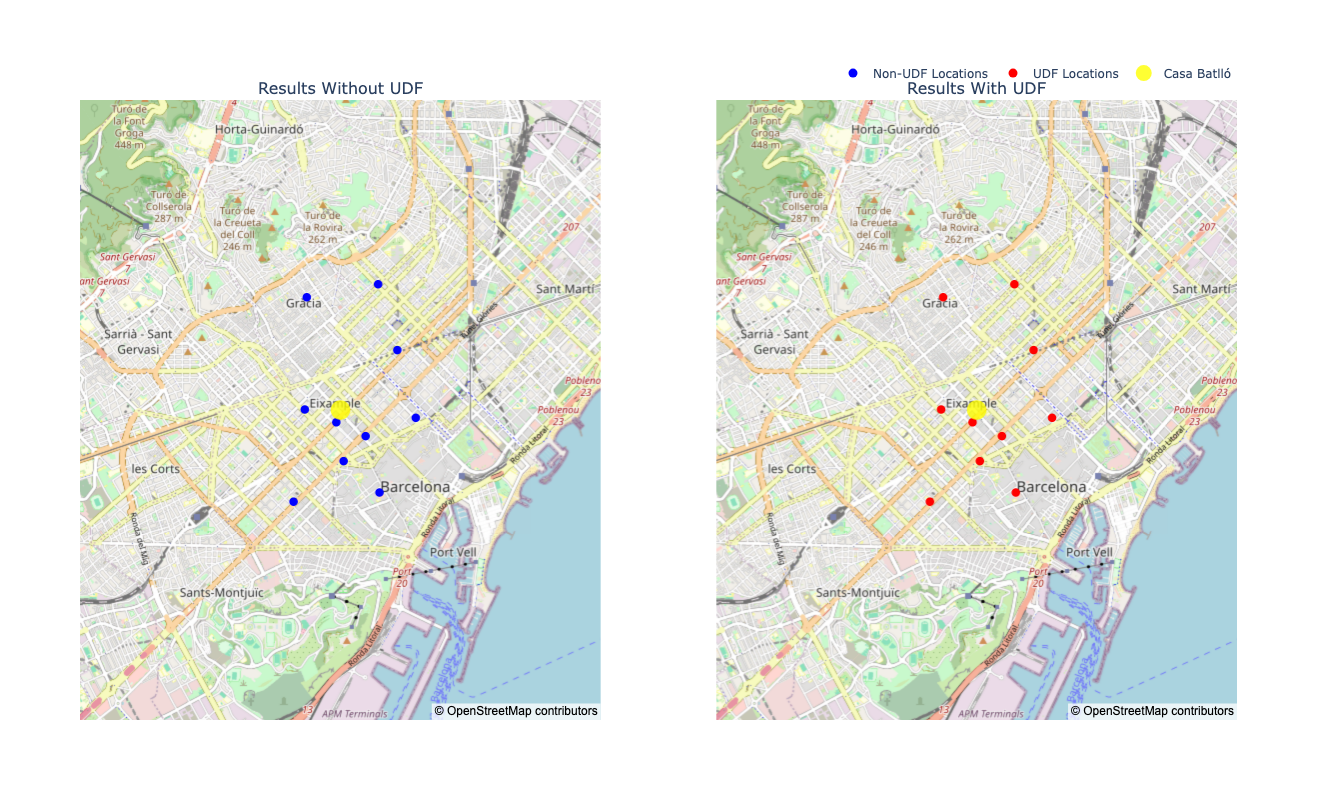

In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Results Without UDF", "Results With UDF"), 
                    specs=[[{'type': 'scattermapbox'}, {'type': 'scattermapbox'}]])

# First plot
latitudes = []
longitudes = []
labels = []
for result in res['search_results']:
    latitudes.append(float(result['part_metadata']['latitude']))
    longitudes.append(float(result['part_metadata']['longitude']))
    labels.append(result['part_metadata']['title'])

fig.add_trace(go.Scattermapbox(
    lat=latitudes,
    lon=longitudes,
    mode='markers',
    marker=dict(size=9, color='blue'),
    text=labels,
    hoverinfo='text',
    name='Non-UDF Locations'
), row=1, col=1)

# Special point for first graph
fig.add_trace(go.Scattermapbox(
    lat=[41.39283635783124],
    lon=[2.164614185406772],
    mode='markers',
    marker=dict(size=20, color='yellow', opacity=0.8),
    text=['Casa Batlló'],
    hoverinfo='text',
    showlegend=False
), row=1, col=1)

# Second plot (UDF Points)
latitudes = []
longitudes = []
labels = []
for result in udf_res['search_results']:
    latitudes.append(float(result['part_metadata']['latitude']))
    longitudes.append(float(result['part_metadata']['longitude']))
    labels.append(result['part_metadata']['title'])

fig.add_trace(go.Scattermapbox(
    lat=latitudes,
    lon=longitudes,
    mode='markers',
    marker=dict(size=9, color='red'),
    text=labels,
    hoverinfo='text',
    name='UDF Locations'
), row=1, col=2)

# Special point for second graph
fig.add_trace(go.Scattermapbox(
    lat=[41.39283635783124],
    lon=[2.164614185406772],
    mode='markers',
    marker=dict(size=20, color='yellow', opacity=0.8),
    text=['Casa Batlló'],
    hoverinfo='text',
    name='Casa Batlló'
), row=1, col=2)

# Update layout
fig.update_layout(
    autosize=True,
    hovermode='closest',
    width=1600,
    height=800,
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=41.39283635783124, lon=2.164614185406772),
        zoom=12
    ),
    mapbox2=dict(
        style="open-street-map",
        center=dict(lat=41.39283635783124, lon=2.164614185406772),
        zoom=12
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

## Datetime Operations

In many applications, it may be important to sort the results based on some datetime data. For our example, we would likely want to see the most recent reviews because those most accurately reflect the current state of the Airbnb. However, we do not want to completely ignore the relevancy of the review's content to our query. Thus, we will use the amount of time since the review was posted as a penalty to the original document score.

Since dates can go back a long time, we will ensure that the final document score is non-negative by taking the maximum of the udf calculation and 0. Our user defined function for this example is

`max(10 * get('$.score') - hours(seconds(to_unix_timestamp(now()) - to_unix_timestamp(datetime_parse(get('$.part_metadata.review_date'), 'yyyy-MM-dd')))) / 24 / 365, 0)`

Take note of the steps needed to perform this calculation:

1. First, we converted all of our date strings to datetime objects (specifically, the `review_date`), specifying the format of the date strings.
2. Next, we converted these dates to the number of seconds from the epoch using `to_unix_timestamp()`, which is necessary to subtract the two datetime objects.
3. We then used the `seconds()` function to indicate that the number we got from our previous operation is a duration in seconds.
4. After this, we converted the seconds duration object to the number of hours between these two dates.
5. Then we calculated the number of years between these two dates by dividing by the number of hours in a day (24) and number of days in a year (365).

In [71]:
# Without UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 10,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [72]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nDate: {result['part_metadata']['review_date']}\n")

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing everything, if it's not a short walk its a short cab ride. The apartment is large with plenty of space, three bedrooms, one double, one larger single and bunk beds. Two bathrooms, one full shower and one half. Full kitchen and large living/dining room.  Its a walk up, maybe 5 short flights of stairs. Next time I'm in Barcelona I'll definitely try and stay here.
Score: 0.9472835659980774
Date: 2019-02-28
Review: If youre looking for an airbnb in Barcelona look no further! The place looks great, is very clean and the staff is great. You get hotel quality with the advantages that an airbnb has to offer like a nice full kitchen. The location is also very central to everything in the city. You can easily take the metro anywhere. The balcony is a very nice t

In [2]:
# With UDF Reranker

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 20,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "max(10 * get('$.score') - hours(seconds(to_unix_timestamp(now()) - to_unix_timestamp(datetime_parse(get('$.part_metadata.review_date'), 'yyyy-MM-dd')))) / 24 / 365, 0)"
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [70]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nDate: {result['part_metadata']['review_date']}\n")

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing everything, if it's not a short walk its a short cab ride. The apartment is large with plenty of space, three bedrooms, one double, one larger single and bunk beds. Two bathrooms, one full shower and one half. Full kitchen and large living/dining room.  Its a walk up, maybe 5 short flights of stairs. Next time I'm in Barcelona I'll definitely try and stay here.
Score: 5.103880405426025
Date: 2019-02-28
Review: If youre looking for an airbnb in Barcelona look no further! The place looks great, is very clean and the staff is great. You get hotel quality with the advantages that an airbnb has to offer like a nice full kitchen. The location is also very central to everything in the city. You can easily take the metro anywhere. The balcony is a very nice to

## Conditional Expressions

The last aspect that we will cover in this notebook is conditional expressions. These allow you to condition the function used to calculate the reranking score. For example, suppose that you would like to give preference to Airbnbs with high overall ratings, but you will likely be more trusting of the rating if there are a large number of total reviews. We can use conditional expressions to complete this task.

Note the difference here between using conditional expressions in your `user_function` and using a `metadata_filter`. If you want to only include Airbnb results that satisfy a particular requirement, add this to the `metadata_filter`. For example, if you need at least 4 beds in the Airbnb to fit everyone in your family, you should include this as a metadata filter: `"metadata_filter": "doc.number_of_beds >= 4"`. On the other hand, if you want to change your calculation based on some metadata, you can add this as a condition to your `user_function`. In this example, we will favor Airbnbs that have at least 200 reviews by giving a multiplier to the scores of those Airbnbs. Here is the `user_function` that we will use for this:

`if (get('$.document_metadata.number_of_reviews) >= 200) 5 * get('$.score') + 1.25 * get($.document_metadata.overall_rating) else 5 * get('$.score') + get($.document_metadata.overall_rating)`

Let's compare the results when using a UDF function without conditional expression vs. with a conditional expression:

In [28]:
# Without Conditional Expression

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    # "metadata_filter": "doc.number_of_beds >= 4",
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 20,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "5 * get('$.score') + get($.document_metadata.overall_rating)"
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [30]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\nNumber of Reviews: {result['part_metadata']['number_of_reviews']}\nNumber of Beds: {result['document_metadata']['number_of_beds']}\n")

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing everything, if it's not a short walk its a short cab ride. The apartment is large with plenty of space, three bedrooms, one double, one larger single and bunk beds. Two bathrooms, one full shower and one half. Full kitchen and large living/dining room.  Its a walk up, maybe 5 short flights of stairs. Next time I'm in Barcelona I'll definitely try and stay here.
Score: 0.9472835659980774
Overall Rating: 4.54
Number of Reviews: 41
Number of Beds: 5

Review: If youre looking for an airbnb in Barcelona look no further! The place looks great, is very clean and the staff is great. You get hotel quality with the advantages that an airbnb has to offer like a nice full kitchen. The location is also very central to everything in the city. You can easily take the

In [24]:
# With Conditional Expression

import requests
import json

url = f"https://api.vectara.io/v2/corpora/{corpus_key}/query"

payload = json.dumps({
  "query": "I want an AirBnb that has a full kitchen and dining room.",
  "search": {
    "metadata_filter": "doc.number_of_beds >= 4",
    "lexical_interpolation": 0.025,
    "offset": 0,
    "limit": 20,
    "context_configuration": {
      "sentences_before": 0,
      "sentences_after": 0
    },
    "reranker": {
      "type": "chain",
      "rerankers": [
        {
          "type": "customer_reranker",
          "reranker_name": "Rerank_Multilingual_v1"
        },
        {
          "type": "mmr",
          "diversity_bias": 0.2
        },
        {
          "type": "userfn",
          "user_function": "if (get('$.document_metadata.number_of_reviews) >= 500) 5 * get('$.score') + 1.25 * get($.document_metadata.overall_rating) else 5 * get('$.score') + get($.document_metadata.overall_rating)"
        }
      ]
    }
  },
  "stream_response": False
})
headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json',
  'x-api-key': api_key
}

response = requests.request("POST", url, headers=headers, data=payload)
res = response.json()

In [27]:
for result in res['search_results'][:10]:
    print(f"Review: {result['part_metadata']['review']}\nScore: {result['score']}\nOverall Rating: {result['document_metadata']['overall_rating']}\nNumber of Reviews: {result['part_metadata']['number_of_reviews']}\nNumber of Beds: {result['document_metadata']['number_of_beds']}\n")

Review: Great apartment in an excellent location! The neighbourhood is beautiful and perfect for tourists, and located beside a quaint square with good bars a restaurants. The city is very walkable and this is a great location for seeing everything, if it's not a short walk its a short cab ride. The apartment is large with plenty of space, three bedrooms, one double, one larger single and bunk beds. Two bathrooms, one full shower and one half. Full kitchen and large living/dining room.  Its a walk up, maybe 5 short flights of stairs. Next time I'm in Barcelona I'll definitely try and stay here.
Score: 0.9472835659980774
Overall Rating: 4.54
Number of Reviews: 41
Number of Beds: 5

Review: Numa hosts a modern spotless 3 bed/2 bath apartment on the bustling La Rambla street next to Mercado de La Boqueria. The apartment is on the second floor. It has an elevator. One bathroom is en suite with the master bedroom and the other full bathroom is in the main hall. There is a living room, dinin

Notice how the results with more reviews tend to be higher up on the list of retrieved documents even if their overall rating scores are slightly lower than some of the other Airbnbs below them in the search results. We also applied a metadata filter so that the number of beds is at least 4.